# 🚀 Space Launch Mission Success Analysis
##  Group Presentation 5

**Team Members:**  
- Reham Abuarqoub, 9062922
- Erica Holden, 5490685
- Yu-Chen Chou (Tracy), 9006160 



#  Term Project - Space Mission Dataset Extension
We use the Global Space Mission Launches dataset. This data provides historical records of launch events, locations, companies, rocket types, and success status. According to the dataset, we implement a simple linear regression to analyze the X independent variable and the y dependent variable, and explore the analysis of Homoscedasticity and R-Squared Measure.

## Step1: Load dataset

In [5]:
# Import library
import pandas as pd

# Load a CSV file into a DataFrame
df = pd.read_csv('./data/Space_Corrected.csv')

# Display the first few rows of the DataFrame
df.head()

,Unnamed: 0.1,Unnamed: 0,Company Name,Location,Datum,Detail,Status Rocket,Rocket,Status Mission
0,0,0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA","Fri Aug 07, 2020 05:12 UTC",Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,50.0,Success
1,1,1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...","Thu Aug 06, 2020 04:01 UTC",Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,29.75,Success
2,2,2,SpaceX,"Pad A, Boca Chica, Texas, USA","Tue Aug 04, 2020 23:57 UTC",Starship Prototype | 150 Meter Hop,StatusActive,NaN,Success
3,3,3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan","Thu Jul 30, 2020 21:25 UTC",Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,65.0,Success
4,4,4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA","Thu Jul 30, 2020 11:50 UTC",Atlas V 541 | Perseverance,StatusActive,145.0,Success


## Step2: Clean dataset and check missing values

In [8]:
# Import library
from sklearn.preprocessing import LabelEncoder

# Define a class for cleaning the space mission dataset
class SpaceMissionCleaner:
    def __init__(self, df):
        self.df = df

    def clean(self):
        df = self.df.copy()
        df.columns = df.columns.str.strip()
        df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True, errors='ignore')
        df['Datum'] = pd.to_datetime(df['Datum'], errors='coerce')
        df.dropna(inplace=True)
        df['Rocket'] = pd.to_numeric(df['Rocket'], errors='coerce')
        df = df[df['Rocket'] > 0]
        df['Success'] = df['Status Mission'].apply(lambda x: 1 if 'Success' in x else 0)
        df['Company Code'] = LabelEncoder().fit_transform(df['Company Name'])
        return df
 
df_clean = SpaceMissionCleaner(df).clean()
df_clean.head()

,Company Name,Location,Datum,Detail,Status Rocket,Rocket,Status Mission,Success,Company Code
0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA",2020-08-07 05:12:00+00:00,Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,50.00,Success,1,18
1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...",2020-08-06 04:01:00+00:00,Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,29.75,Success,1,2
3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan",2020-07-30 21:25:00+00:00,Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,65.00,Success,1,17
4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA",2020-07-30 11:50:00+00:00,Atlas V 541 | Perseverance,StatusActive,145.00,Success,1,19
5,CASC,"LC-9, Taiyuan Satellite Launch Center, China",2020-07-25 03:13:00+00:00,"Long March 4B | Ziyuan-3 03, Apocalypse-10 & N...",StatusActive,64.68,Success,1,2


In [9]:
# Check for missing values
missing_values = df_clean.isnull().sum()
print("Missing values in each column:")
print(missing_values)
print("\n")

# Check the data types of each column
print("Data types of each column:")
print(df_clean.info())

Missing values in each column:
Company Name      0
Location          0
Datum             0
Detail            0
Status Rocket     0
Rocket            0
Status Mission    0
Success           0
Company Code      0
dtype: int64


Data types of each column:
<class 'pandas.core.frame.DataFrame'>
Index: 943 entries, 0 to 4020
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   Company Name    943 non-null    object             
 1   Location        943 non-null    object             
 2   Datum           943 non-null    datetime64[ns, UTC]
 3   Detail          943 non-null    object             
 4   Status Rocket   943 non-null    object             
 5   Rocket          943 non-null    float64            
 6   Status Mission  943 non-null    object             
 7   Success         943 non-null    int64              
 8   Company Code    943 non-null    int64              
dtypes: datetime64[n

## Step 3: Implement a Simple Linear Regression
(1) Company vs Space Missions Success

In [10]:
# Define a class for rocket cost and success analyzer
class RocketSuccessAnalyzer:
    def __init__(self, df, rocket_col='Rocket', success_col='Success'):
        self.df = df.copy()
        self.rocket_col = rocket_col
        self.success_col = success_col
        self.binned_data = None # Stores the DataFrame after binning
        self.success_rate_by_bin = None # Stores the success rate calculated per bin

    def bin_rocket_cost(self, bins=10, duplicates='drop'):
        self.df['Rocket_bin'] = pd.qcut(self.df[self.rocket_col], q=bins, duplicates=duplicates)
        return self.df

    def calc_success_rate_per_bin(self):
        success_rate_by_rocket = self.df.groupby('Rocket_bin', observed=True)[self.success_col].mean().reset_index()
        success_rate_by_rocket['Rocket_Median'] = success_rate_by_rocket['Rocket_bin'].apply(lambda x: x.mid)
        self.binned_df = success_rate_by_rocket
        return success_rate_by_rocket


# Initialize the analysis object
analyzer = RocketSuccessAnalyzer(df_clean)

# Binning
analyzer.bin_rocket_cost(bins=10)

# Calculate the success rate (including the median rocket cost)
success_rate_per_bin_df = analyzer.calc_success_rate_per_bin()

# Display the success rate per bin
print("Success Rate per Rocket Cost Bin:")
print(success_rate_per_bin_df)

Success Rate per Rocket Cost Bin:
                    Rocket_bin   Success Rocket_Median
0  (5.2989999999999995, 29.15]  0.875000       17.2245
1                (29.15, 31.0]  0.978261       30.0750
2                 (31.0, 40.0]  0.920455       35.5000
3                 (40.0, 50.0]  0.899160       45.0000
4                 (50.0, 62.0]  0.951807       56.0000
5                 (62.0, 85.0]  0.929412       73.5000
6                (85.0, 120.0]  0.989011      102.5000
7               (120.0, 200.0]  0.977612      160.0000
8               (200.0, 450.0]  0.979592      325.0000


In [13]:
# Import library and function
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Define X independent variable and y dependent variable
X = success_rate_per_bin_df[['Rocket_Median']] # continuous numerical substitution
y = success_rate_per_bin_df['Success']

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Predicting 'Rocket_Median' with the Model
y_pred = model.predict(X)

# Display the model's intercept and coefficient
print("Intercept:", model.intercept_)
print("Slope:", model.coef_[0])

Intercept: 0.9226998526852046
Slope: 0.0002320197447846532


- Intercept is about 0.9227. Indicates that when the rocket cost approaches 0 (theoretically unlikely), the estimated mission success rate is about 92.27%. If the cost is extremely low, maybe this model's baseline success rate.
- The slope is about 0.000232. Indicates that for every unit increase in rocket cost (assuming the same currency unit), the mission success rate increases by about 0.0232%. In this case, the slope is very small. Even with the cost increases, the success rate increases very slowly.

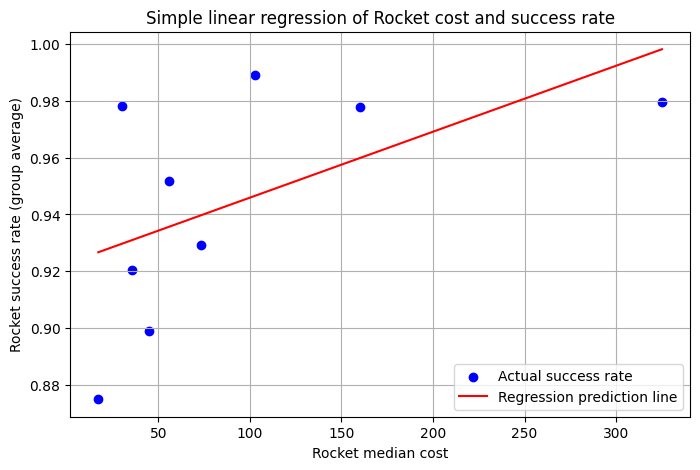

In [14]:
# Define a class for plotting linear regression results
class RegressionPlotter:
    def __init__(self, X, y, y_pred):
        self.X = X
        self.y = y
        self.y_pred = y_pred

    def plot_regression(self):
        plt.figure(figsize=(8,5))
        plt.scatter(self.X, self.y, color='blue', label='Actual success rate')
        plt.plot(self.X, self.y_pred, color='red', label='Regression prediction line')
        plt.xlabel('Rocket median cost')
        plt.ylabel('Rocket success rate (group average)')
        plt.title('Simple linear regression of Rocket cost and success rate')
        plt.legend()
        plt.grid()
        plt.show()

# Create an instance of RegressionPlotter and plot the regression
plotter = RegressionPlotter(X, y, y_pred)
plotter.plot_regression()

- The blue scatter points represent the "average success rate in the range" corresponding to the "median rocket cost range" after grouping.
- The red straight line is the fitting line of the simple linear regression model, showing the trend of success rate changing with cost.
- The scatter points show a slight upward trend, verifying that there is a positive relationship between cost and success rate, but the trend is mild and close to flat.
- The success rate in the low-cost and medium-high cost range is about 0.9 or above, reflecting that the overall success rate is already quite high, and the impact of rocket cost on the success rate improvement is limited.

## Step 4: Homoscedasticity 

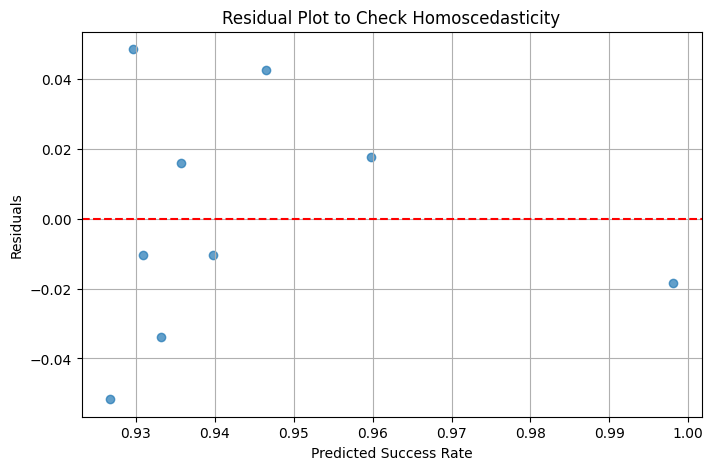

In [15]:
# Define a class for plotting residuals to check homoscedasticity
class ResidualPlotter:
    def __init__(self, y_true, y_pred):
        self.y_true = y_true
        self.y_pred = y_pred
        self.residuals = self.y_true - self.y_pred
    
    def plot_residuals(self):
        plt.figure(figsize=(8,5))
        plt.scatter(self.y_pred, self.residuals, alpha=0.7)
        plt.axhline(0, color='red', linestyle='--')
        plt.xlabel('Predicted Success Rate')
        plt.ylabel('Residuals')
        plt.title('Residual Plot to Check Homoscedasticity')
        plt.grid()
        plt.show()

# Create an instance of ResidualPlotter and plot the residuals
plotter = ResidualPlotter(y, y_pred)
plotter.plot_residuals()

- The number of data points is small, which makes it difficult and uncertain to judge the pattern.
- The residual distribution is a positive sign, with no obvious "scalloped" or "funnel-shaped" pattern observed. The model is likely to meet the assumption of Heteroscedasticity.

## Step 5: R-Squared Measure

In [16]:
# Calculate R-squared
r2 = model.score(X, y)

# Print R-squared value
print("R-squared:", r2)

R-squared: 0.3078738172869736


The R-squared is about 30.79%, but there are still about 69.21% of the variation that cannot be captured by this simple linear regression model. There may be other important factors that affect the success rate.

(2) Company Code vs Space Missions Success Rate 

Intercept: 0.8056137010679503
Slope: 0.0008933616069438918


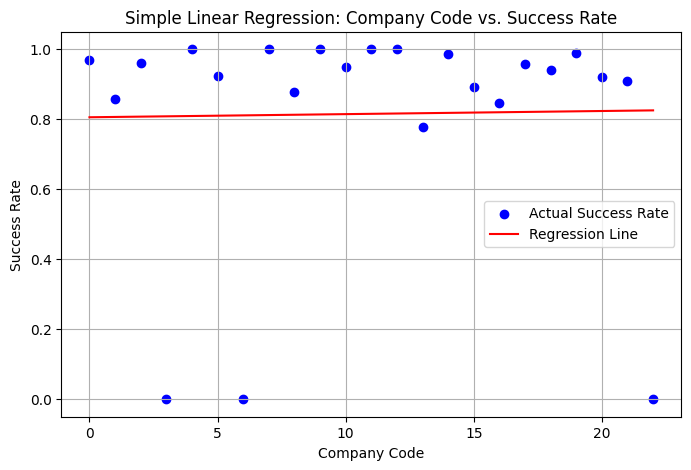

In [17]:
class CompanySuccessRegression:
    def __init__(self, df, company_col='Company Code', success_col='Success'):
        self.df = df.copy()
        self.company_col = company_col
        self.success_col = success_col
        self.company_stats = None
        self.model = None
        self.y_pred = None

    def prepare_success_rate(self):
        stats = self.df.groupby(self.company_col)[self.success_col].mean().reset_index()
        stats.columns = [self.company_col, 'Success_Rate']
        self.company_stats = stats
        return stats

    def fit_regression(self):
        if self.company_stats is None:
            self.prepare_success_rate()
        X = self.company_stats[[self.company_col]]
        y = self.company_stats['Success_Rate']
        self.model = LinearRegression()
        self.model.fit(X, y)
        self.y_pred = self.model.predict(X)
        return self.model
    
    def print_params(self):
        if self.model is None:
            raise ValueError("Please run fit_regression() first.")
        print(f"Intercept: {self.model.intercept_}")
        print(f"Slope: {self.model.coef_[0]}")

    def plot_regression(self):
        if self.company_stats is None or self.y_pred is None:
            raise ValueError("Please run fit_regression() first.")
        X = self.company_stats[[self.company_col]]
        y = self.company_stats['Success_Rate']

        plt.figure(figsize=(8,5))
        plt.scatter(X, y, color='blue', label='Actual Success Rate')
        plt.plot(X, self.y_pred, color='red', label='Regression Line')
        plt.xlabel('Company Code')
        plt.ylabel('Success Rate')
        plt.title('Simple Linear Regression: Company Code vs. Success Rate')
        plt.legend()
        plt.grid()
        plt.show()

reg = CompanySuccessRegression(df_clean)
reg.prepare_success_rate()
reg.fit_regression()
reg.print_params()      
reg.plot_regression()   

(3) Year vs Space Missions Success Rate 

Intercept: -1.0283968704294315
Slope: 0.0009818886179571015


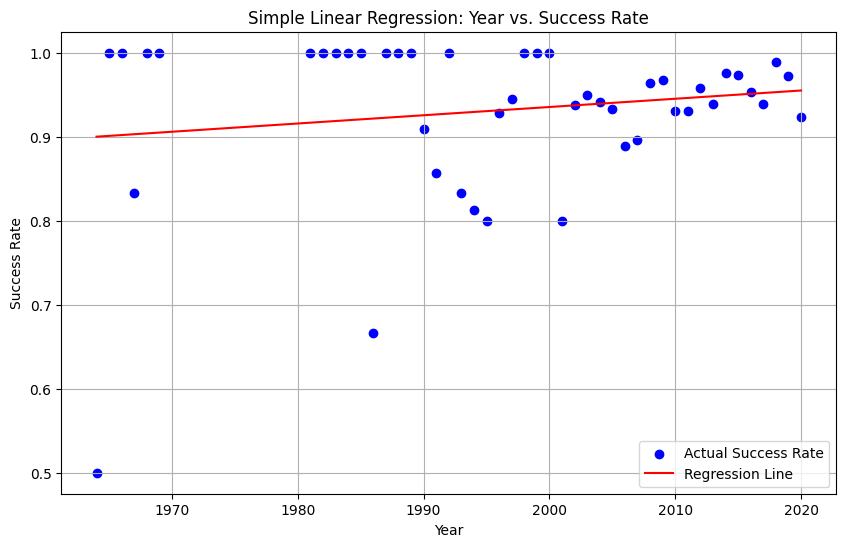

In [18]:
class YearlySuccessRegression:
    def __init__(self, df, date_col='Datum', success_col='Success'):
        self.df = df.copy()
        self.date_col = date_col
        self.success_col = success_col
        self.yearly_stats = None
        self.model = None
        self.y_pred = None

    def prepare_yearly_success_rate(self):
        self.df['Year'] = pd.to_datetime(self.df[self.date_col]).dt.year
        stats = self.df.groupby('Year')[self.success_col].mean().reset_index()
        stats.columns = ['Year', 'Success_Rate']
        self.yearly_stats = stats
        return stats

    def fit_regression(self):
        if self.yearly_stats is None:
            self.prepare_yearly_success_rate()
        X = self.yearly_stats[['Year']]
        y = self.yearly_stats['Success_Rate']
        self.model = LinearRegression()
        self.model.fit(X, y)
        self.y_pred = self.model.predict(X)
        return self.model
    
    def print_params(self):
        if self.model is None:
            raise ValueError("Please run fit_regression() first.")
        print(f"Intercept: {self.model.intercept_}")
        print(f"Slope: {self.model.coef_[0]}")

    def plot_regression(self):
        if self.yearly_stats is None or self.y_pred is None:
            raise ValueError("Please run fit_regression() first.")
        X = self.yearly_stats['Year']
        y = self.yearly_stats['Success_Rate']

        plt.figure(figsize=(10,6))
        plt.scatter(X, y, color='blue', label='Actual Success Rate')
        plt.plot(X, self.y_pred, color='red', label='Regression Line')
        plt.xlabel('Year')
        plt.ylabel('Success Rate')
        plt.title('Simple Linear Regression: Year vs. Success Rate')
        plt.legend()
        plt.grid()
        plt.show()

reg = YearlySuccessRegression(df_clean)
reg.prepare_yearly_success_rate()
reg.fit_regression()
reg.print_params()
reg.plot_regression()